In [1]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Project Path Setup
from setup_project_path import check_and_add_project_path  # Script to check and add project path
check_and_add_project_path()

# Import Custom Modules
from src.all_custom_modules import DiscrError, DlrKernel, cf, DataInterp, plot_data, Hdf5Kernel # Consolidated custom modules import


Project path successfully added.


In [2]:
#Define filename of hdf5 file holding the data and create Hdf5Kernel object associated with the file
filename = f'../data/delta_t=0.1.h5'

#Create instance of Hdf5Kernel
h5_kernel = Hdf5Kernel(filename=filename)

In [3]:
#Extract the relevant data for plotting from hdf5 file. Assemble it conveniently into multidimensional arrays.
data_h5, kernel_dims = h5_kernel.read_to_array()

errors = data_h5["errors"]
m_vals = data_h5["m_vals"]
n_vals = data_h5["n_vals"]
h_vals = data_h5["h_vals"]
N_maxs = data_h5["N_maxs"]
betas = data_h5["betas"]
delta_t_vals = data_h5["delta_t_vals"]
ID_ranks = data_h5["ID_ranks"]

nbr_modes_total = m_vals + n_vals
print(f"Dimensions of data arrays: {kernel_dims}.")

Dimensions of data arrays: [8 2 4].


In [4]:
#Set global plot parameters
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica", "font.size": 8})

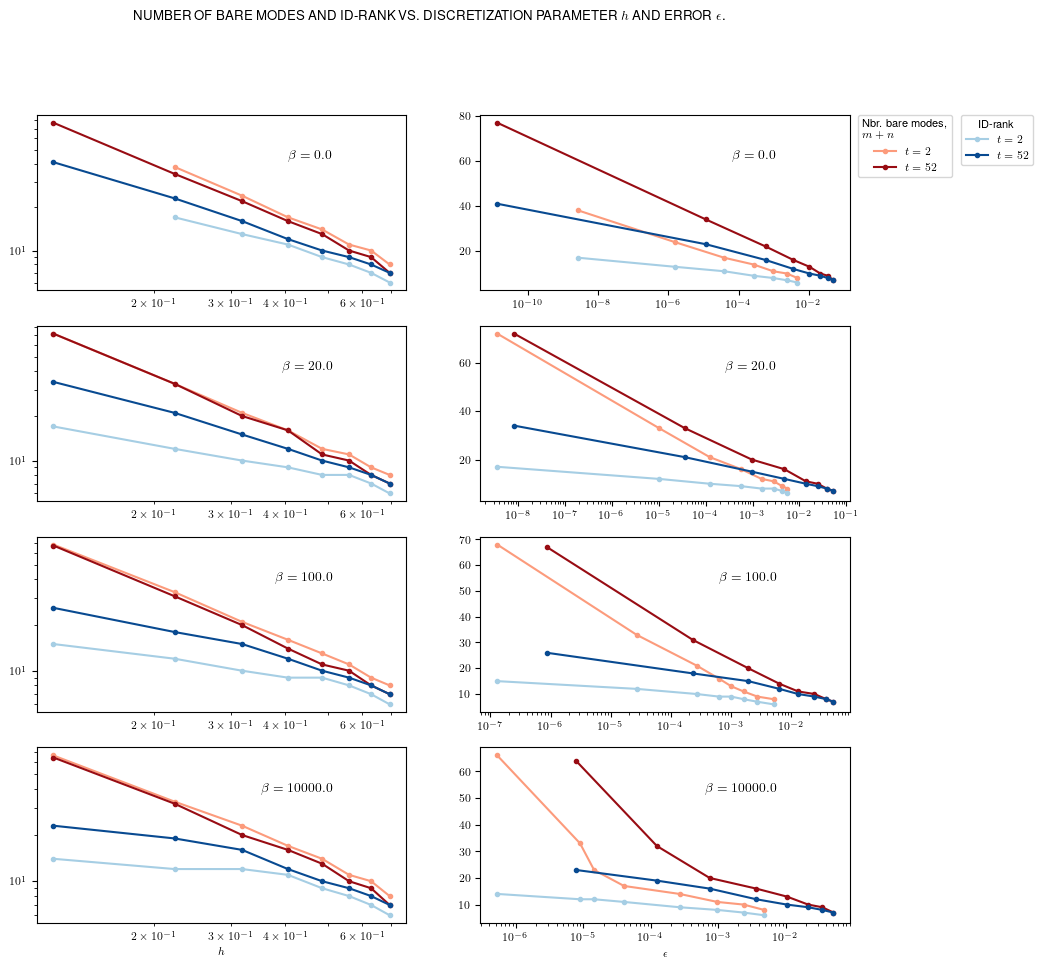

In [5]:
#_____Plot the number of modes versus the error and the discretization parameter h____
fig, axs = plt.subplots(kernel_dims[2], 2, figsize=(10.5, 10.5))
fig.suptitle(f'NUMBER OF BARE MODES AND ID-RANK VS. DISCRETIZATION PARAMETER $h$ AND ERROR $\epsilon$.')

cmaps = [plt.get_cmap("Blues"), plt.get_cmap("Reds")]
colors_blue = cmaps[0](np.linspace(0.35, 0.9, kernel_dims[1]))
colors_orange = cmaps[1](np.linspace(0.35, 0.9, kernel_dims[1]))

for b in range (kernel_dims[2]):
    for tau in range (kernel_dims[1]):
        mask = errors[:,tau,b] > 1.e-12#mask to filter values that are zero (i.e. no value avaliable)
        
        axs[b,0].plot(h_vals[mask, tau, b],nbr_modes_total[mask,tau,b],color=colors_orange[tau],marker="o",linestyle="-",markersize=3, label = r'$t={}$'.format(int(np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]))))
        axs[b,0].plot(h_vals[mask, tau, b], ID_ranks[mask,tau,b], color=colors_blue[tau], marker="o", linestyle="-", markersize=3)

        axs[b,1].plot(errors[mask, tau, b],nbr_modes_total[mask,tau,b] ,color=colors_orange[tau],marker="o",linestyle="-",markersize=3)
        axs[b,1].plot(errors[mask, tau, b], ID_ranks[mask,tau,b], color=colors_blue[tau], marker="o", linestyle="-", markersize=3, label = r'$t={}$'.format(int(np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]))))


    axs[b, 0].set_title(r'$\beta = {}$'.format(betas[0,0,b]), loc='right', x=.8, y=0.7)
    axs[b, 1].set_title(r'$\beta = {}$'.format(betas[0,0,b]), loc='right', x=.8, y=0.7)

    axs[b,0].set_yscale("log")   
    axs[b,0].set_xscale("log")  
    axs[b,1].set_xscale("log")

axs[-1,0].set_xlabel(r"$h$")
axs[-1,1].set_xlabel(r"$\epsilon$")

# Create legends and place them outside the rightmost subplot
legend1 = axs[0,0].legend(title=f'Nbr. bare modes,\n $m+n$', loc='upper left', bbox_to_anchor=(2.22, 1), borderaxespad=0.)
legend2 = axs[0,1].legend(title=f'ID-rank', loc='upper left', bbox_to_anchor=(1.3, 1), borderaxespad=0.)

#plt.savefig("../plots/modes_vs_error.pdf", bbox_inches='tight')


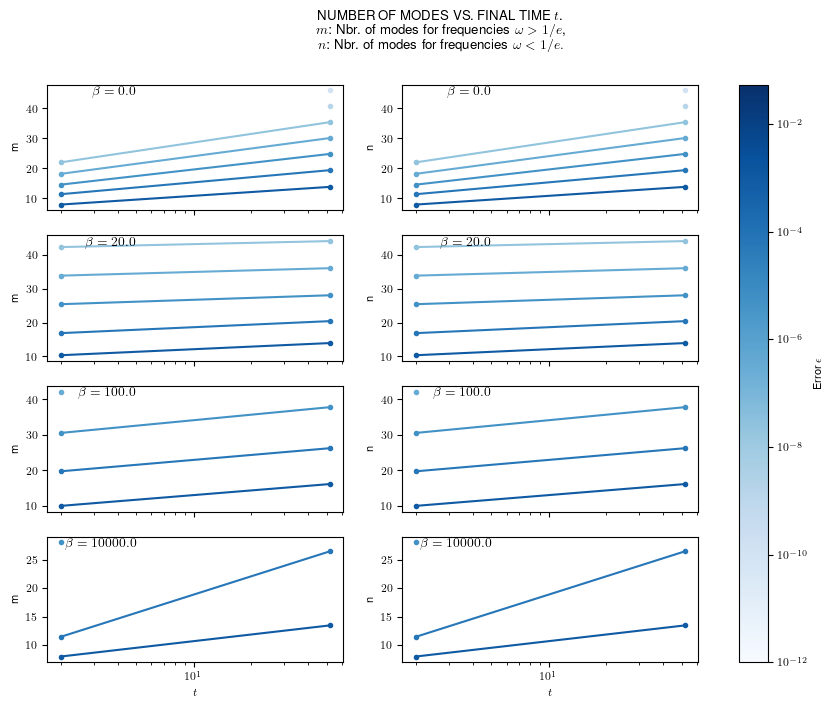

In [6]:
cmap = plt.get_cmap("Blues")

# Configuration and data preparation
error_grid = np.logspace(-10, -3, 7)
colors = cmap(np.linspace(0.35, 0.9, len(error_grid)))

fig, axs = plt.subplots(kernel_dims[2], 2, figsize=(10.5, 7.5), sharex=True)
fig.suptitle(f'NUMBER OF MODES VS. FINAL TIME $t$.\n $m$: Nbr. of modes for frequencies $\omega > 1/e$,\n $n$: Nbr. of modes for frequencies $\omega < 1/e.$')

    

n_vals_interp = np.zeros((len(error_grid), kernel_dims[1]))
m_vals_interp = np.zeros((len(error_grid), kernel_dims[1]))

t_data = np.array([np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]) for tau in range (kernel_dims[1])])


cutoff = 1.e-12
# Use logarithmic normalization
norm = mcolors.LogNorm(vmin=cutoff, vmax=np.max(errors))

# Interpolation and plotting
for b in range (kernel_dims[2]):
    for tau in range (kernel_dims[1]):
        mask = errors[:,tau,b] > cutoff # Mask to filter values clearly above machine precision
        N_VALS_INTERP = DataInterp(errors[mask, tau,b], n_vals[mask, tau,b])
        M_VALS_INTERP = DataInterp(errors[mask, tau,b], m_vals[mask, tau,b])

        n_vals_interp[:, tau] = N_VALS_INTERP.interp(error_grid, x_scale='log')
        m_vals_interp[:, tau] = M_VALS_INTERP.interp(error_grid, x_scale='log')
    
    
    for eps_iter, eps_val in enumerate(error_grid):
        label = f'${eps_val:.1e}$'  # Scientific notation for error values
        #plot only nonzero values
        mask_m = m_vals_interp[eps_iter, :] > 0.
        mask_n = n_vals_interp[eps_iter, :] > 0.

        axs[b,0].plot(t_data[mask_m], m_vals_interp[eps_iter, mask_m], marker="o", linestyle="-", markersize=3, color=cmap(norm(eps_val)), label=label)
        axs[b,1].plot(t_data[mask_n], m_vals_interp[eps_iter, mask_n], marker="o", linestyle="-", markersize=3, color=cmap(norm(eps_val)), label=label)
        


    axs[b, 0].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .3, y=0.85)
    axs[b, 1].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='right', x = .3, y=0.85)
    
    axs[b,0].set_ylabel('m')
    axs[b,1].set_ylabel('n')
    
# Setting labels and legend
axs[-1,0].set_xlabel(r'$t$')
axs[-1,1].set_xlabel(r'$t$')

axs[-1,0].set_xscale('log')
axs[-1,1].set_xscale('log')


# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Error '+r'$\epsilon$')

#axs[0,1].legend(title='Error ' + r'$\epsilon:$', loc='upper left', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
#plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the layout to fit the legend

#plt.savefig("../plots/modes_vs_time.pdf", bbox_inches='tight')


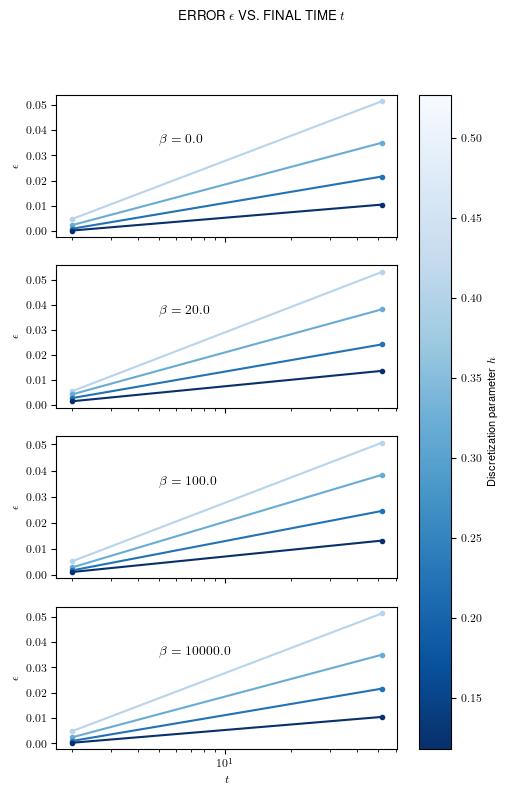

In [9]:
# Choose a colormap
cmap = plt.get_cmap('Blues_r')  

fig, axs = plt.subplots(kernel_dims[2], 1, figsize=(5.5, 8.5), sharex=True)
fig.suptitle(f'ERROR $\epsilon$ VS. FINAL TIME $t$')


t_data = np.array([np.max(N_maxs[:,tau,:] * delta_t_vals[:,tau,:]) for tau in range (kernel_dims[1])])


start_index = 4
# Normalize h_val values to the 0-1 range
norm = mcolors.Normalize(vmin=np.min(h_vals[h_vals > 0.]), vmax=1.3*np.max(h_vals[start_index:]))

for b in range (kernel_dims[2]):
    h_vals_loop = [np.max(h_vals[h,:,b]) for h in range (start_index,kernel_dims[0])]

    for h_idx, h_val in enumerate(h_vals_loop):
        
        mask = errors[h_idx,:,b] > 1.e-14
        axs[b].plot(t_data[mask], errors[h_idx,mask,b], color = cmap(norm(h_val)), marker="o",linestyle="-",markersize=3)
    

    axs[b].set_title(r'$\beta = {}$'.format(np.max(betas[:,:,b])), loc='left', x=.3, y=.6)
    
    # Setting labels and legend
    
    axs[b].set_ylabel(r'$\epsilon$')

axs[-1].set_xlabel(r'$t$')
axs[-1].set_xscale('log')


# Add a colorbar to the figure
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is necessary because we're not using sm with imshow or similar
cbar = plt.colorbar(sm, ax=axs)
cbar.set_label('Discretization parameter '+r'$h$')

#plt.savefig("../plots/modes_vs_time.pdf", bbox_inches='tight')
